In [1]:
# <%matplotlib inline> goes well for vscode
# %matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# data preprocessing before use
import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
# load the dataset
from data_processing import data_loading, data_cutoff, test_data_prepare

doe_num=4
# doe_num=5
# get to know the start position and number of segments for each drilling file
file_base="../data/dataset/DoE/"+str(doe_num) + "/"
file_indice=file_base+"Drilling_layers_indice.csv"
df= pd.read_csv(file_indice, header=None)
df.columns= ['start_seg', 'nb_segs']
start_segs= df['start_seg'].values
nb_segs= df['nb_segs'].values

file_data_base= file_base + "Drilling_layers_"
file_label_base= file_base+"Pulse_label_para_" + str(doe_num) + "_doe_"

vol_all=np.empty((0, 200))
cur_all=np.empty((0, 200))
labels_all=np.empty((0, 1))

numbers_to_cutoff=[
    [690000, 0], [500000, 0], [380000, 0], [1100000, 0],
    [970000, 0], [1070000, 0], [1130000, 0], [1150000, 0]
]
vols_max= [170, 170, 170, 110, 110, 170, 110, 110]
curs_max= [30, 30, 30, 30, 25, 30, 25, 25]

for i in range(3, 4, 1):
    if i==0:
        number_to_cutoff=[88000, 1000]
    elif i==1 or i==2 or i==3:
        number_to_cutoff= numbers_to_cutoff[doe_num-1]
    
    file_data= file_data_base + str(i+1) + ".tdms"
    file_label= file_label_base + str(i+1) + ".csv"
    
    vol, cur, labels= data_loading(file_data, file_label,
                            start_seg=start_segs[i], nb_segs=nb_segs[i])
    vol_all=   np.concatenate((vol_all, vol), axis=0)
    cur_all=   np.concatenate((cur_all, cur), axis=0)
    labels_all=np.concatenate((labels_all, labels), axis=0)
    del vol, cur, labels

vol_all, cur_all, labels_all= data_cutoff(vol_all, cur_all, labels_all,
                                        number_to_cutoff=number_to_cutoff)
X_test, y_test= test_data_prepare(
    vol_all, cur_all, labels_all, vol_max=vols_max[doe_num-1], cur_max=curs_max[doe_num-1], cur_min=0
)
number_of_pulses=40000
X_test=X_test[:number_of_pulses, ...]
y_test=y_test[:number_of_pulses, ...]

Good! we now have 1624000 number of pulses!
We have retrieved 1624000 pulses!


In [ ]:
# load the trained model
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'lib/')))
# from attention import Attention
from my_attention import Attention

mdl_tcn= tf.keras.models.load_model("../data/model/tcn/comparison/mdl_tcn_v0.h5", custom_objects={'Attention': Attention}) 
mdl_lstm= tf.keras.models.load_model("../data/model/lstm/comparison/mdl_bilstm_v0.h5", custom_objects={'Attention': Attention}) 

In [ ]:
from plot_gradcam_ig import CAM_integrated_gradients, Input_integrated_gradients

def make_input_feature_importance(input_seq, mdl, pred_index=None):
    """
    input_seq: the input to be predicted with gradients derived
    model: full model used build of sub-model
    """
    input_data= tf.Variable(input_seq)
    # print(input_data)
    # remove last layer's softmax
    model= mdl
    model.layers[-1].activation= None

    with tf.GradientTape() as tape:
        preds= model(input_data, training=False)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    grads = tape.gradient(class_channel, input_data)
    # print(f'grads:{grads.shape}')

    pooled_grads = grads[0]
    # print(f'pooled_grads:{pooled_grads.shape}')

    return pooled_grads


def attention_score(input_seq, model):
    att_mdl= keras.models.Model(inputs= model.input, 
                                outputs=model.get_layer('attention').output)

    _, att_score= att_mdl.predict(input_seq)
    att_score=np.squeeze(att_score)
    att_score= att_score / np.max(att_score)

    return att_score


def plot_all_heatmap(model_tcn, model_lstm, input_data,
                    vol_max_tmp=160, vol_min=-10, cur_max_tmp=30, cur_min=0, 
                    num_heatmaps_tcn=2, num_heatmaps_lstm=2):
    import numpy as np
    import matplotlib
    from matplotlib import pyplot as plt
    from matplotlib import gridspec
    # from plot_gradcam import make_gradcam_heatmap
    matplotlib.rcParams.update({'font.size': 7})
    matplotlib.rcParams["font.family"] = "Arial"
    matplotlib.rcParams.update({'axes.linewidth': 1})
    linewidth=1.5

    plt_vol_sig= input_data[:, 0]*(vol_max_tmp - vol_min)+vol_min
    plt_cur_sig= input_data[:, 1]*(cur_max_tmp - cur_min)+cur_min

    height_ratio=[1]*(7+num_heatmaps_tcn+num_heatmaps_lstm)
    height_ratio.append(3)
    height_ratio[5]=0.2 # blank space
    fig, axs= plt.subplots(7+num_heatmaps_tcn+num_heatmaps_lstm+1, 1, 
                           gridspec_kw={'height_ratios':height_ratio,
                                        'hspace':0.2,},
                           figsize=(3,6), dpi=300)
    p1, =axs[-1].plot(plt_vol_sig, 'tab:green', linewidth=linewidth, label='voltage')
    axs[-1].set_ylim([vol_min, vol_max_tmp*2.2])
    axs[-1].set_ylabel("Voltage/ V")
    axs[-1].set_xlabel("Time instance")
    axs2= axs[-1].twinx()
    p2, =axs2.plot(plt_cur_sig, 'tab:orange', linewidth=linewidth, label='current')
    axs2.set_ylim([cur_min-1, cur_max_tmp*1.2])
    axs2.set_ylabel("Current/ A")
    axs2.set_xlim([0, len(plt_cur_sig)])
    # set color for edge and ticks
    axs[-1].yaxis.label.set_color(p1.get_color())
    axs[-1].spines["left"].set_edgecolor(p1.get_color())
    axs[-1].tick_params(axis='y', colors=p1.get_color())
    axs2.yaxis.label.set_color(p2.get_color())
    axs2.spines['left'].set_visible(False)  
    axs2.spines["right"].set_edgecolor(p2.get_color())
    axs2.tick_params(axis='y', colors=p2.get_color())

    # FOR TCN (on top):
    last_layer_name= 'tcn_sfm'
    # input importance
    input_seq= tf.convert_to_tensor(input_data)
    input_seq= input_seq[tf.newaxis,...]
    # grads_tcn=make_input_feature_importance(input_seq, mdl_tcn)
    grads_tcn= Input_integrated_gradients(mdl_tcn, input_data, last_layer_name)
    grads_vol= grads_tcn[:,0]
    grads_vol /= np.max(np.abs(grads_vol), axis=0)
    shw_in= axs[0].imshow(np.atleast_2d(grads_vol), cmap= 'Spectral', aspect='auto', vmin=-1, vmax=1)
    axs[0].set_xticklabels("")
    axs[0].set_yticklabels("")
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    grads_cur= grads_tcn[:,1]
    grads_cur /= np.max(np.abs(grads_cur), axis=0)
    shw_in= axs[1].imshow(np.atleast_2d(grads_cur), cmap= 'Spectral', aspect='auto', vmin=-1, vmax=1)
    axs[1].set_xticklabels("")
    axs[1].set_yticklabels("")
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    #  hidden features
    for i in range(2, num_heatmaps_tcn+2):
        if i==2:
            for j in range(4):
                hidden_layer_name='tcn1_conv_0_'+str(j)
                heatmap= CAM_integrated_gradients(model_tcn, input_data, hidden_layer_name, last_layer_name)
        else:
            for j in range(4):
                hidden_layer_name='tcn2_conv_0_'+str(j)
                heatmap= CAM_integrated_gradients(model_tcn, input_data, hidden_layer_name, last_layer_name)
        shw= axs[i].imshow(np.atleast_2d(heatmap), aspect='auto', vmin=0, vmax=1)
        axs[i].set_xticklabels("")
        axs[i].set_yticklabels("")
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    # attention 
    att_score= attention_score(input_seq, model_tcn)
    shw_att= axs[i+1].imshow(np.atleast_2d(att_score), cmap='plasma', aspect='auto', vmin=0, vmax=0.5)
    axs[i+1].set_xticklabels("")
    axs[i+1].set_yticklabels("")
    axs[i+1].set_xticks([])
    axs[i+1].set_yticks([])


    # leave for blank space
    axs[i+2].set_visible(False)


    # For LSTM (on second top):
    #  input importance
    last_layer_name= 'residual_lstm__sfm'
    # grads_lstm=make_input_feature_importance(input_seq, mdl_lstm)
    grads_lstm= Input_integrated_gradients(mdl_lstm, input_data, last_layer_name)
    grads_vol= grads_lstm[:,0]
    grads_vol /= np.max(np.abs(grads_vol), axis=0)
    shw_in= axs[i+3].imshow(np.atleast_2d(grads_vol), cmap='Spectral', aspect='auto', vmin=-1, vmax=1)
    axs[i+3].set_xticklabels("")
    axs[i+3].set_yticklabels("")
    axs[i+3].set_xticks([])
    axs[i+3].set_yticks([])
    grads_cur= grads_lstm[:,1]
    grads_cur /= np.max(np.abs(grads_cur), axis=0)
    shw_in= axs[i+4].imshow(np.atleast_2d(grads_cur), cmap='Spectral', aspect='auto', vmin=-1, vmax=1)
    axs[i+4].set_xticklabels("")
    axs[i+4].set_yticklabels("")
    axs[i+4].set_xticks([])
    axs[i+4].set_yticks([])
    # hidden features
    for i in range(8, 8+num_heatmaps_lstm):
        if i==8:
            hidden_layer_name='bidirectional'
        elif i==9:
            hidden_layer_name='bidirectional_1'
        heatmap= CAM_integrated_gradients(model_lstm, input_data, hidden_layer_name, last_layer_name)
        shw= axs[i].imshow(np.atleast_2d(heatmap), aspect='auto', vmin=0, vmax=1)
        axs[i].set_xticklabels("")
        axs[i].set_yticklabels("")
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    # attention 
    att_score= attention_score(input_seq, model_lstm)
    shw_att= axs[i+1].imshow(np.atleast_2d(att_score), cmap='plasma', aspect='auto', vmin=0, vmax=0.5)
    axs[i+1].set_xticklabels("")
    axs[i+1].set_yticklabels("")
    axs[i+1].set_xticks([])
    axs[i+1].set_yticks([])

    # add space for colour bar
    fig.subplots_adjust(right=0.65)
    cbar_ax = fig.add_axes([0.75, 0.7, 0.04, 0.15]) # left,bottom,width,height
    fig.colorbar(shw_in, cax=cbar_ax)
    cbar_ax = fig.add_axes([0.75, 0.5, 0.04, 0.15]) # left,bottom,width,height
    fig.colorbar(shw, cax=cbar_ax)
    cbar_ax = fig.add_axes([0.75, 0.3, 0.04, 0.15]) # left,bottom,width,height
    fig.colorbar(shw_att, cax=cbar_ax)

    plt.text(-20,1.25, 'HD-CNN',  fontsize=10, rotation=90)
    plt.text(-20,0.20, 'Bi-LSTM', fontsize=10, rotation=90)
    # LSTM
    plt.text(-17.5,-0.05, 'ATN', fontsize=7, rotation=90)
    plt.text(-17.5,0.15, 'FT2',  fontsize=7, rotation=90)
    plt.text(-17.5,0.35, 'FT1',  fontsize=7, rotation=90)
    plt.text(-17.5,0.55, 'CUR',  fontsize=7, rotation=90)
    plt.text(-17.5,0.75, 'VOL',  fontsize=7, rotation=90)
    # TCN
    plt.text(-17.5,1.03, 'ATN', fontsize=7, rotation=90)
    plt.text(-17.5,1.23, 'FT2',  fontsize=7, rotation=90)
    plt.text(-17.5,1.43, 'FT1',  fontsize=7, rotation=90)
    plt.text(-17.5,1.63, 'CUR',  fontsize=7, rotation=90)
    plt.text(-17.5,1.83, 'VOL',  fontsize=7, rotation=90)

    # fig.tight_layout()
    plt.show()

integrated gradients:(200, 2)
integrated gradients:(200, 2)


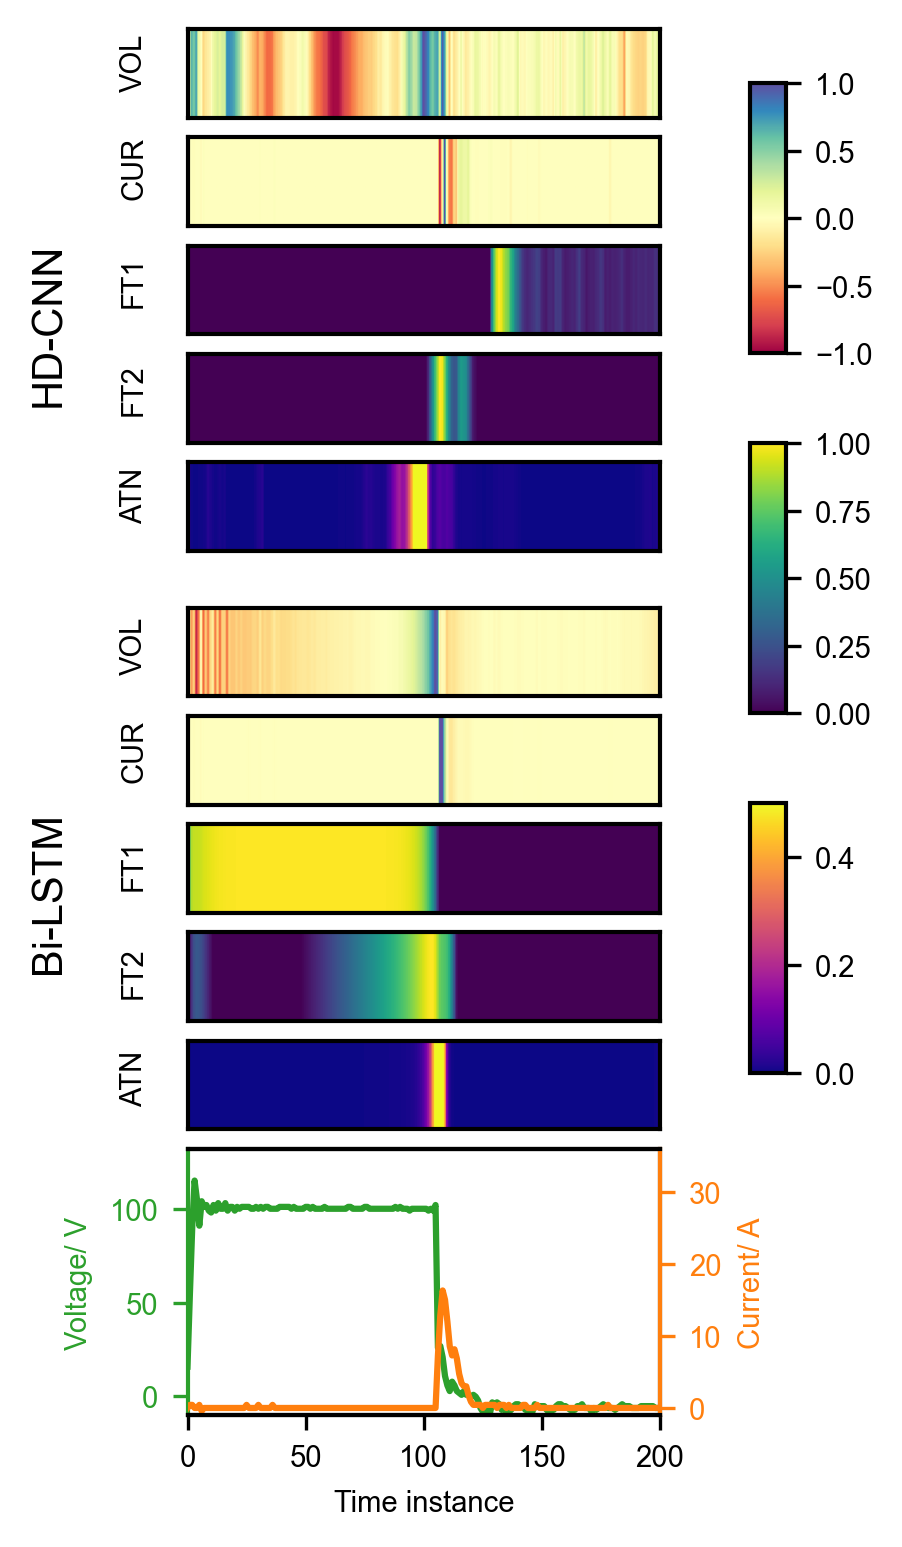

In [ ]:
# Correct predictions:
vols_max= [170, 170, 170, 60, 110, 170, 110, 110]
curs_max= [30, 30, 30, 30, 25, 30, 25, 25]

# Index being chosen
input_data= X_test[9521].numpy()
plot_all_heatmap(mdl_tcn, mdl_lstm, input_data,
                vol_max_tmp=vols_max[doe_num-1],
                cur_max_tmp=curs_max[doe_num-1])

integrated gradients:(200, 2)
integrated gradients:(200, 2)


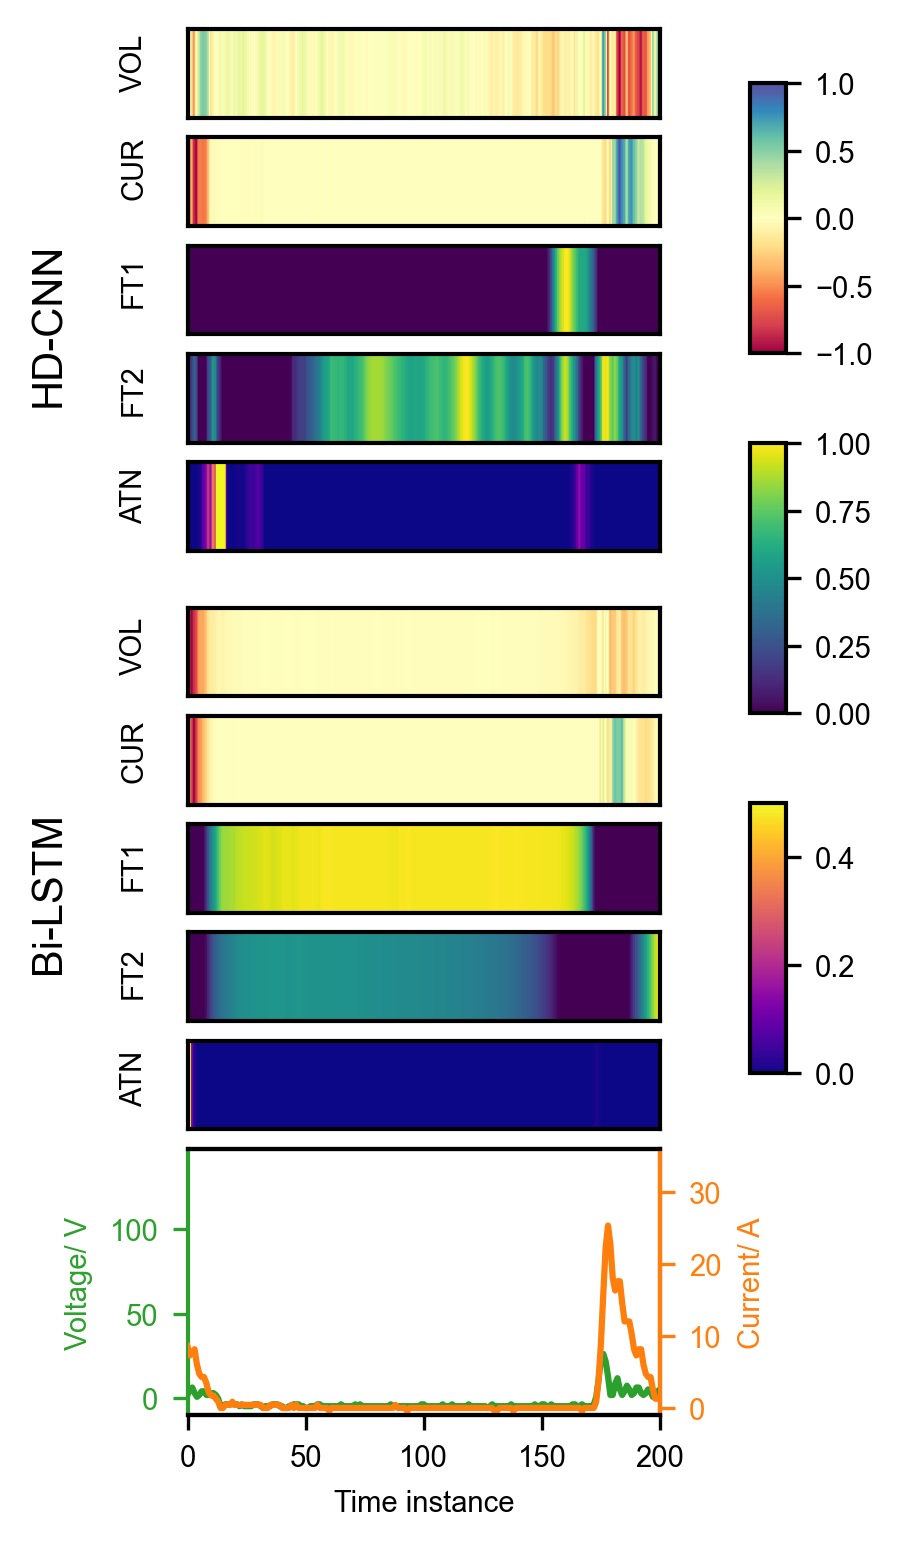

In [ ]:
# False predictions:
vols_max= [170, 170, 170, 67, 110, 170, 110, 110]
curs_max= [30, 30, 30, 30, 25, 30, 25, 25]

# Index being chosen
input_data= X_test[30687].numpy()
input_data_md= np.copy(input_data) # for Arc-30688
input_data_md[174,0]=0.82
plot_all_heatmap(mdl_tcn, mdl_lstm, input_data,
                vol_max_tmp=vols_max[doe_num-1],
                cur_max_tmp=curs_max[doe_num-1])